# Converting cuisine dataset to dataframe and hence to Network Graph format.

Import libraries

In [1]:
import json
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import re
import networkx as nx
from collections import Counter
import time
# Ignore matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

Import input dataset 

In [2]:
# read the train.json file as data
j_file = open('train.json',)
train_data = json.load(j_file)
train_data[8:10] # list of dictionaries with id, cuisine and ingredients.

[{'id': 16903,
  'cuisine': 'mexican',
  'ingredients': ['olive oil',
   'purple onion',
   'fresh pineapple',
   'pork',
   'poblano peppers',
   'corn tortillas',
   'cheddar cheese',
   'ground black pepper',
   'salt',
   'iceberg lettuce',
   'lime',
   'jalapeno chilies',
   'chopped cilantro fresh']},
 {'id': 12734,
  'cuisine': 'italian',
  'ingredients': ['chopped tomatoes',
   'fresh basil',
   'garlic',
   'extra-virgin olive oil',
   'kosher salt',
   'flat leaf parsley']}]

In [3]:
len(train_data)

39774

In [4]:
type(train_data)

list

## Convert data in dictionary format to pandas dataframe

In [5]:
# read in the data from the dictionary into pandas dataframe in one line of code
# set index to the id column 
df_train = pd.DataFrame.from_dict(train_data)
df_train = df_train.set_index('id')

In [6]:
df_train.head(5)

,cuisine,ingredients
id,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,indian,"[water, vegetable oil, wheat, salt]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [7]:
df_train['cuisine'].nunique()  # number of unique cuisine

20

In [8]:
df_train['cuisine'].unique()  # names of cuisine

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [9]:
#List of all ingredients: list of lists
nested_list_ings = list(df_train.ingredients)

In [10]:
# convert a list of lists to one list in order to extract stop words
flat_list_ings =[item for sublist in nested_list_ings for item in sublist]

In [11]:
len(flat_list_ings)

428275

We search and remove stop words which frequently present on dataset as a part of cleaning.

In [12]:
# stop word search
stop_words_all = [w for w in flat_list_ings if re.search(r'\b ?salt|pepper|sauce|water|seasoning|powder?\b', w)]
len(stop_words_all)

85323

In [13]:
#convert list to set to get unique stop words
stop_words_set = set(stop_words_all)

In [14]:
#add new column which do not contain stop words
df_train['ingredients_nostopw'] = df_train['ingredients'].apply(lambda x : list(set(x)-stop_words_set))

In [15]:
df_train.shape

(39774, 3)

In [16]:
df_train.head()

,cuisine,ingredients,ingredients_nostopw
id,,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[grape tomatoes, garbanzo beans, black olives,..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[thyme, plain flour, yellow corn meal, tomatoe..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[grilled chicken breasts, mayonaise, yellow on..."
22213,indian,"[water, vegetable oil, wheat, salt]","[wheat, vegetable oil]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[cornflour, lemon juice, boneless chicken skin..."


Removing columns with single value only in the ingredients

In [17]:
#new dataframe with removing list with single items on ingredients_nostopw column
df_train_ext = df_train[df_train['ingredients_nostopw'].apply(lambda x: len(x) > 1)]

In [18]:
df_train_ext.shape

(39633, 3)

Creating tuple of ingredients and corresponding weight of their presence together.

In [19]:
#start = time.time()
# from the list of ingredients in a column in given dataframe, this piece will
# return a dictionary of tuples and their weight depending on their presence in a given cuisine.
dic_ings = {}
for i in range(len(df_train_ext)):
    ing_rows = df_train_ext['ingredients_nostopw'].iloc[i]
    for ing in ing_rows:
        for ing2 in ing_rows:
            if ing != ing2:
                tup_ings = (ing,ing2)
                if tup_ings in dic_ings.keys():
                    dic_ings[tup_ings] += 1
                else:
                    dic_ings[tup_ings]  = 1
#print(f'{time.time()-start} seconds')

In [20]:
#dic_ings

In [21]:
df_train_dict = pd.DataFrame.from_dict(dic_ings, orient = 'index').reset_index()
df_train_dict.head()

,index,0
0,"(grape tomatoes, garbanzo beans)",2
1,"(grape tomatoes, black olives)",4
2,"(grape tomatoes, purple onion)",54
3,"(grape tomatoes, garlic)",49
4,"(grape tomatoes, feta cheese crumbles)",15


In [22]:
df_train_dict['source']= df_train_dict['index'].apply(lambda x: str(x).split(',')[0].replace('(',''))

In [23]:
df_train_dict['target']= df_train_dict['index'].apply(lambda x: str(x).split(',')[1].replace(')',''))

In [24]:
#df_train_dict.head()

In [25]:
df_train_dict = df_train_dict.rename(columns = {0: 'weight'})

In [26]:
#df_train_dict1.head()

In [27]:
df_train_dict['source'] = df_train_dict['source'].replace("\'",'', regex = True) 
df_train_dict['target'] = df_train_dict['target'].replace("\'",'', regex = True) 

In [28]:
df_train_dict['source'] = df_train_dict['source'].replace(r"^\s?",'', regex = True) 
df_train_dict['target'] = df_train_dict['target'].replace(r"^\s?",'', regex = True) 

In [29]:
df_train_dict.head()

,index,weight,source,target
0,"(grape tomatoes, garbanzo beans)",2,grape tomatoes,garbanzo beans
1,"(grape tomatoes, black olives)",4,grape tomatoes,black olives
2,"(grape tomatoes, purple onion)",54,grape tomatoes,purple onion
3,"(grape tomatoes, garlic)",49,grape tomatoes,garlic
4,"(grape tomatoes, feta cheese crumbles)",15,grape tomatoes,feta cheese crumbles


In [30]:
df_train_final = df_train_dict[['source', 'target', 'weight']].copy() 

In [31]:
df_train_final.head(10)

,source,target,weight
0,grape tomatoes,garbanzo beans,2
1,grape tomatoes,black olives,4
2,grape tomatoes,purple onion,54
3,grape tomatoes,garlic,49
4,grape tomatoes,feta cheese crumbles,15
5,grape tomatoes,romaine lettuce,16
6,garbanzo beans,grape tomatoes,2
7,garbanzo beans,black olives,2
8,garbanzo beans,purple onion,16
9,garbanzo beans,garlic,54


In [32]:
df_train_final.shape

(729862, 3)

In [33]:
#df_train_final.to_csv('All_recipe.csv', index = False)  # save dataframe as csv file

In [34]:
df_train_final_st = df_train_final[['source','target']]

In [35]:
df_train_final_st.head()

,source,target
0,grape tomatoes,garbanzo beans
1,grape tomatoes,black olives
2,grape tomatoes,purple onion
3,grape tomatoes,garlic
4,grape tomatoes,feta cheese crumbles


In [36]:
df_train_final_st.to_csv('All_recipe_st.csv', index = False)  # save dataframe as csv file only source and target column

Exploring Graph properties

In [37]:
#unique source
uni_source = list(df_train_final.source.unique())
len(uni_source)

6157

In [38]:
#unique target
uni_target = list(df_train_final.target.unique())
len(uni_target)

6184

## Convert dataframe to Network Graph

In [39]:
G_all = nx.from_pandas_edgelist(df_train_final,'source', 'target',['weight'])

In [40]:
print(nx.info(G_all))

Name: 
Type: Graph
Number of nodes: 6192
Number of edges: 364435
Average degree: 117.7116


In [41]:
len(G_all.edges())

364435

In [42]:
len(G_all.nodes())

6192

In [43]:
all_node_list = [f for f, to, edata in G_all.edges(data = True)]
all_node_list_unique = list(set(all_node_list))

In [44]:
len(all_node_list_unique)

3694

In [45]:
selected_edges = [(u,v,e) for u,v,e in G_all.edges(data=True) if e['weight'] == 150]
print(selected_edges)

[('garlic', 'parsley', {'weight': 150}), ('eggs', 'scallions', {'weight': 150}), ('onions', 'fresh lemon juice', {'weight': 150}), ('sugar', 'cinnamon sticks', {'weight': 150}), ('olive oil', 'ground beef', {'weight': 150}), ('chopped cilantro fresh', 'black beans', {'weight': 150}), ('all-purpose flour', 'shortening', {'weight': 150}), ('sesame seeds', 'rice vinegar', {'weight': 150})]


In [46]:
def island_fun(G, weight):
    '''
    Returns a subgraph from a big graph based on the
    selected weight.
    '''
    G1 = nx.Graph()
    for f, to, edata in G.edges(data=True):
         if edata['weight'] == weight:
                G1.add_edge(f,to, weight = edata['weight'])
    return G1

In [47]:
island_fun(G_all, 150).edges(data = True)

EdgeDataView([('garlic', 'parsley', {'weight': 150}), ('eggs', 'scallions', {'weight': 150}), ('onions', 'fresh lemon juice', {'weight': 150}), ('sugar', 'cinnamon sticks', {'weight': 150}), ('olive oil', 'ground beef', {'weight': 150}), ('chopped cilantro fresh', 'black beans', {'weight': 150}), ('all-purpose flour', 'shortening', {'weight': 150}), ('sesame seeds', 'rice vinegar', {'weight': 150})])

In [48]:
sub_graph100 = island_fun(G_all, 100)
node_list = [f for f, to, edata in sub_graph100.edges(data = True)]
node_list_unique = list(set(node_list))
node_list_unique

['sesame oil',
 'dried oregano',
 'cinnamon',
 'chicken broth',
 'potatoes',
 'chopped cilantro fresh',
 'corn starch',
 'flat leaf parsley',
 'sour cream',
 'extra-virgin olive oil',
 'olive oil',
 'chicken stock',
 'garlic',
 'all-purpose flour',
 'fresh lime juice',
 'rice vinegar',
 'vegetable oil',
 'onions',
 'butter']

In [49]:
node_size = [sub_graph100.degree(sub)*200 for sub in node_list_unique] # make node size bigger for visulization
#node_size

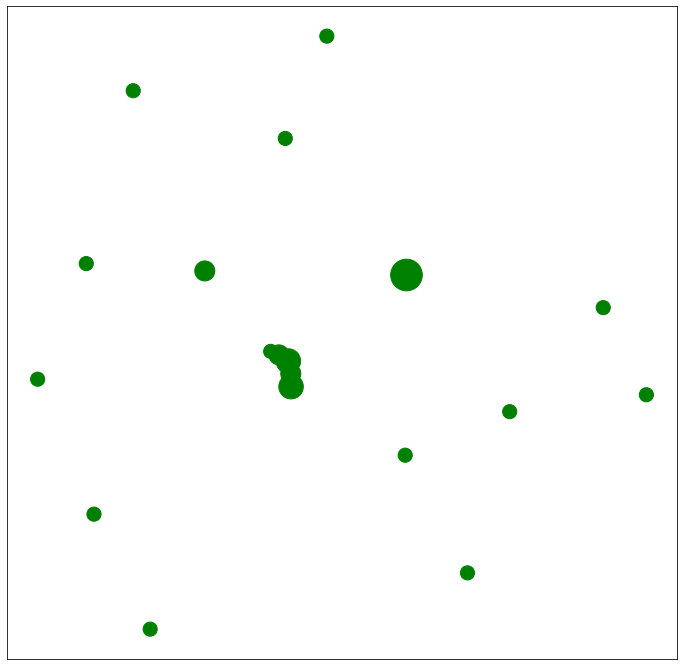

In [50]:
plt.figure(figsize=(12, 12))

layout = nx.spring_layout(sub_graph100,iterations=50)

nx.draw_networkx_nodes(sub_graph100, 
                       layout, 
                       nodelist=node_list_unique, 
                       node_size=node_size, # a LIST of sizes, based on g.degree
                       node_color='green');


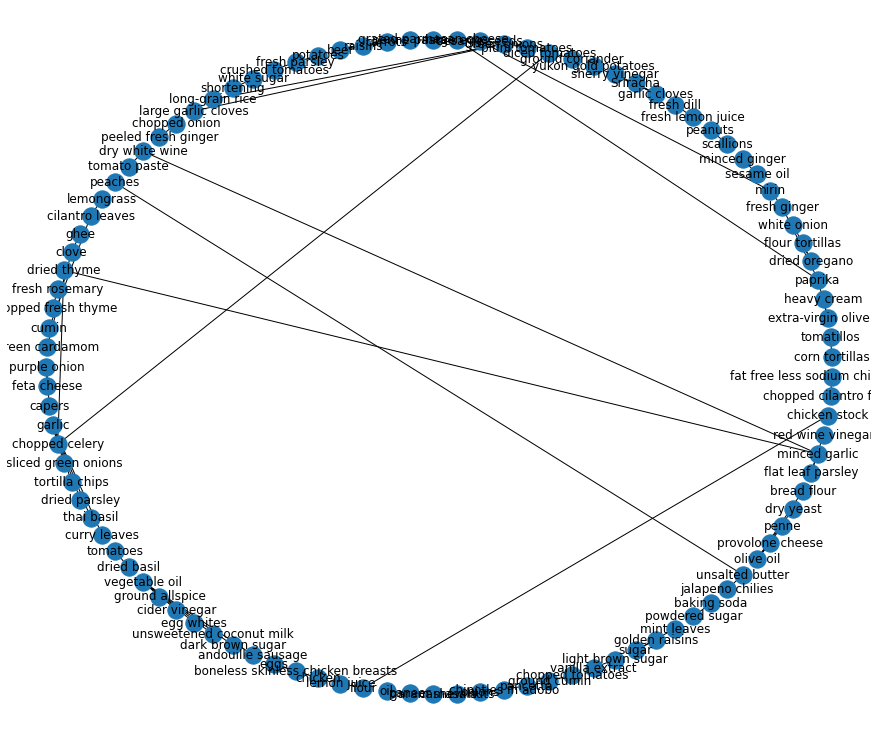

In [51]:
G_plot = island_fun(G_all, 60)
fig = plt.figure(figsize=(12, 10))
nx.draw_shell(G_plot, with_labels=True)
#plt.savefig("Ingredients_Graph.png") # save as png

In [52]:
#plt.savefig("Ingredients_Graph.png") # save as png

## Neighbors extraction from graph 

In [53]:
def extract_neigh(G_in, item_search):
    '''
    Returns list of 5 nearest neighbor items 
    sorted with highest value weight for a given search item.
    '''
    list_nodes = [itm for itm, edata in G_in[item_search].items()]
    list_wt = [edata['weight'] for itm, edata in G_in[item_search].items()]
    data = {'Target_name': list_nodes, 'weight': list_wt}
    df_out = pd.DataFrame(data)    
    df_out = df_out.sort_values('weight', ascending = False).reset_index(drop=True)
    nei_list = df_out.Target_name[0:5]    
    return list(nei_list)

In [54]:
extract_neigh(G_all, 'oil')  # Five nearest neighbors based on weight

['onions', 'garlic', 'sugar', 'ginger', 'tomatoes']